<a href="https://colab.research.google.com/github/JakobRobnik/MicroCanonicalHMC/blob/master/advanced_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced tutorial - Stochastic volatility model

---



Here we work with a harder sampling problem - Stochastic volatility modeling of the returns on the S&P500 index, taken from [here](https://num.pyro.ai/en/latest/examples/stochastic_volatility.html). 

We have $N = 2427$ values of the returns on the S\&P500 index $\{ r_n\}_{n = 1}^{N}$ in the time span of 10 years. Let's download the data and visualize it.

In [ ]:
!pip install numpyro

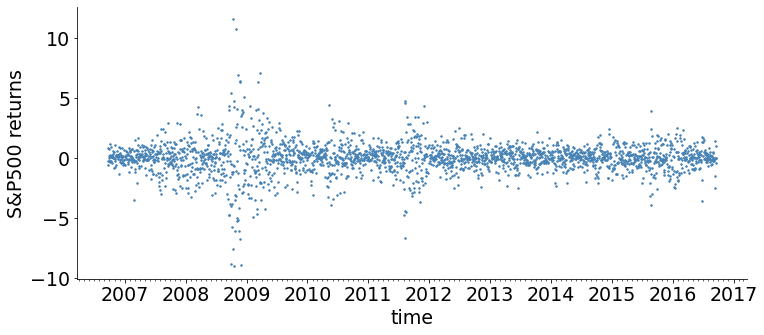

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
plt.rcParams.update({'font.size': 19})

from numpyro.examples.datasets import SP500, load_dataset
from numpyro.distributions import StudentT

# get the data
_, fetch = load_dataset(SP500, shuffle=False)
SP500_dates, SP500_returns = fetch()


# figure setup
plt.figure(figsize = (12, 5))
ax = plt.subplot()
ax.spines['right'].set_visible(False) #remove the upper and the right axis lines
ax.spines['top'].set_visible(False)

ax.xaxis.set_major_locator(mdates.YearLocator()) #dates on the xaxis
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.xaxis.set_minor_locator(mdates.MonthLocator())

# plot data
dates = mdates.num2date(mdates.datestr2num(SP500_dates))
plt.plot(dates, SP500_returns, '.', markersize = 3, color= 'steelblue')
plt.xlabel('time')
plt.ylabel('S&P500 returns')
plt.show()

The returns $r_n$ are modeled by a Student's-t distribution whose scale (volatility) $R_n$ is time varying and unknown. The prior for $\log R_n$ is a Gaussian random walk, with an exponential distribution of the random walk step-size $\sigma$. An exponential prior is also taken for the Student's-t degrees of freedom $\nu$. The generative process of the data is:

\begin{align}
    &r_n / R_n \sim \text{Student's-t}(\nu) \qquad 
    &&\nu \sim \text{Exp}(\lambda = 1/10) \\ \nonumber
    &\log R_n \sim \mathcal{N}(\log R_{n-1}, \sigma) \qquad
    &&\sigma \sim \text{Exp}(\lambda = 1/0.02).
\end{align}
Our task is to find the posterior of the parameters $\{R_n\}_{n =1}^N$, $\sigma$ and $\nu$, given the observed data $\{r_n\}_{n =1}^N$.

We have to make the configuration space unconstrained ($\boldsymbol{x} \in \mathbb{R}^d$). In the original form, the parameters were all positive, so we take the logarithms of our parameters:
\begin{equation}
  \boldsymbol{x} = ( \log R_1,\, \log R_2, \,... \log R_N, \,\log \lambda_{\sigma} \sigma,\, \log \lambda_{\nu} \nu).
\end{equation}

Let's implement an instance of the target density class. `nlogp` $= -\log p(\boldsymbol{x})$ has to be implemented by hand, but the gradient can be computed by jax.
We also define the transform function which maps to the constrained space (essentially taking the exponent of the variables).

In [22]:
import jax
import jax.numpy as jnp


class StochasticVolatility():
    
    def __init__(self):

        self.d = 2429

        self.lambda_sigma, self.lambda_nu = 50, 0.1

        self.grad_nlogp = jax.value_and_grad(self.nlogp) #we compute the gradient using jax


    def nlogp(self, x):
        """- log p of the target distribution"""

        sigma = jnp.exp(x[-2]) / self.lambda_sigma #we used log-transformation to make x unconstrained
        nu = jnp.exp(x[-1]) / self.lambda_nu

        prior2 = (jnp.exp(x[-2]) - x[-2]) + (jnp.exp(x[-1]) - x[-1]) # - log prior(sigma, nu)
        prior1 = (self.d - 2) * jnp.log(sigma) + 0.5 * (jnp.square(x[0]) + jnp.sum(jnp.square(x[1:-2] - x[:-3]))) / jnp.square(sigma) # - log prior(R)
        lik = -jnp.sum(StudentT(df=nu, scale= jnp.exp(x[:-2])).log_prob(SP500_returns)) # - log likelihood

        return lik + prior1 + prior2


    def transform(self, x):
        """transform x back to the parameters R, sigma and nu """
        z = jnp.empty(x.shape)
        z = z.at[:-2].set(jnp.exp(x[:-2])) # = R_n
        z = z.at[-2].set(jnp.exp(x[-2]) / self.lambda_sigma) # = sigma
        z = z.at[-1].set(jnp.exp(x[-1]) / self.lambda_nu) # = nu

        return z


    def prior_draw(self, key):
        """draws x from the prior"""

        key_walk, key_exp1, key_exp2 = jax.random.split(key, 3)

        sigma = jax.random.exponential(key_exp1) / self.lambda_sigma #sigma is drawn from the exponential distribution

        def step(track, useless): #one step of the gaussian random walk
            randkey, subkey = jax.random.split(track[1])
            x = jax.random.normal(subkey, shape= track[0].shape, dtype = track[0].dtype) + track[0]
            return (x, randkey), x

        x = jnp.empty(self.d)
        x = x.at[:-2].set(jax.lax.scan(step, init=(0.0, key_walk), xs=None, length=self.d - 2)[1] * sigma) # = log R_n are drawn as a Gaussian random walk realization
        x = x.at[-2].set(jnp.log(sigma * self.lambda_sigma)) #sigma ~ exponential distribution(lambda_sigma)
        x = x.at[-1].set(jnp.log(jax.random.exponential(key_exp2))) #nu ~ exponential distribution(lambda_nu)

        return x

     

Now we can sample from the defined target using MCHMC.

In [ ]:
!rm -r MicroCanonicalHMC
!git clone https://github.com/JakobRobnik/MicroCanonicalHMC.git

As in the `intro_tutorial` we use the automatic hyperparameter tuning and then take 5000 samples:

In [23]:
from MicroCanonicalHMC.sampling.sampler import Sampler

sampler = Sampler(StochasticVolatility(), integrator= 'LF')
sampler.tune_hyperparameters()

In [25]:
samples = sampler.sample(5000)


Let's visualize the posterior. First, we compute the median $R_n$ and its quartiles:

In [26]:
R = np.array(samples)[:, :-2] #remove sigma and nu parameters
R = np.sort(R, axis = 0) #sort samples for each R_n
num_samples = len(R)

lower_quartile, median, upper_quartile = R[num_samples//4, :], R[num_samples//2, :], R[3*num_samples//4, :]

Now, we can visualize the time dependant volatility:

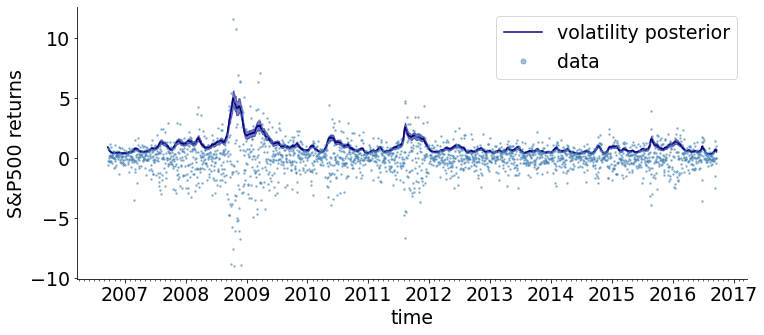

In [27]:
# figure setup
plt.figure(figsize = (12, 5))
ax = plt.subplot()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.xaxis.set_minor_locator(mdates.MonthLocator())


# plot posterior
plt.plot(dates, median, color= 'navy', label = 'volatility posterior')
plt.fill_between(dates, lower_quartile, upper_quartile, color= 'navy', alpha=0.5)


# plot data
plt.plot(dates, SP500_returns, '.', markersize = 3, color= 'steelblue', alpha = 0.5)
plt.plot([], [], '.', markersize = 10, color= 'steelblue', alpha = 0.5, label = 'data') #larger markersize for the legend
plt.xlabel('time')
plt.ylabel('S&P500 returns')
plt.legend()
plt.show()